In [3]:
import os

import numpy as np
import torch
import torch.nn.functional as F

import conf_mgt
from utils import yamlread
from guided_diffusion.script_util import (
    NUM_CLASSES,
    model_and_diffusion_defaults,
    classifier_defaults,
    create_model_and_diffusion,
    create_classifier,
    create_cond_fn,
    select_args,
)  

# data and visualization
#from src.experiments.imputations import get_imputations, store_imputations, load_imputations, plot_imputations, plot_imagenet, ParamsImputation
#from src.experiments.resources import load_data, load_imputer


import matplotlib.pyplot as plt

In [2]:
torch.cuda.device_count()

2

In [4]:
device = torch.device("cuda")

In [4]:
device = torch.device("cpu")

# Test diffusion imputer

In [2]:
import conditional_explainer.imputers.diffusion_based_imputer as diffimp

In [2]:
from src.experiments.imputations import get_imputations, store_imputations, load_imputations, plot_imputations
from src.experiments.resources import load_data, load_imputer
from executable_scripts.visualize_imputations import load_params

from types import SimpleNamespace

Start calculate_attributions.py with index = 4
Using params: {'n_superpixel': 100, 'compactness_slic': 1.0, 'imputer_name': 'diffusion_diffusion_steps=1000_time_steps=125_n_resampling=2_class_conditioning=False', 'root_data': '/media/vielhaben/Data1/ImageNet-complete/val', 'dataset': 'imagenet', 'root_experiments': '/home/vielhaben/git/conditional-explainer/data/experiments'}


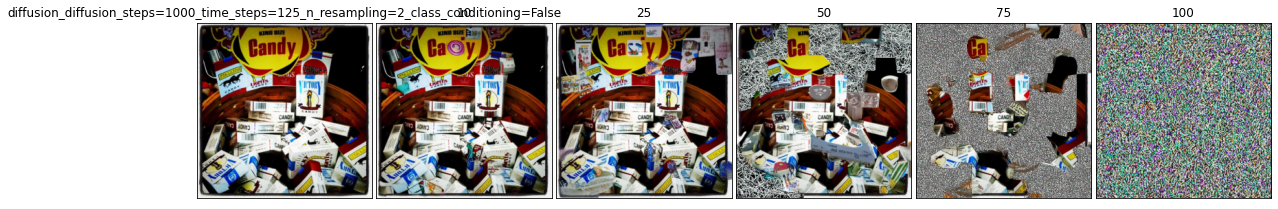

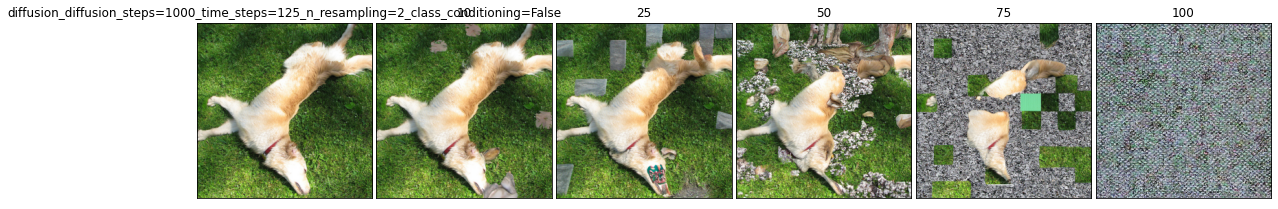

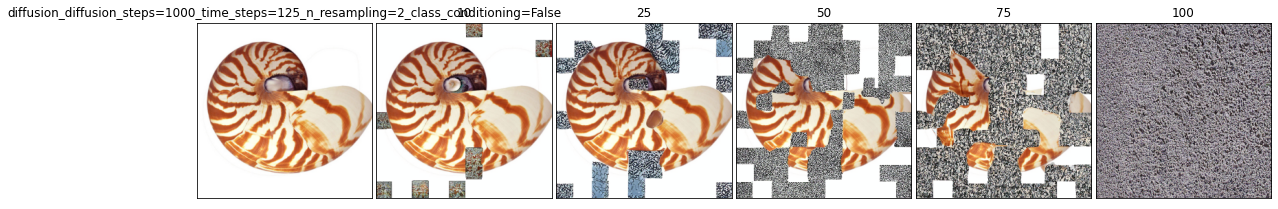

In [3]:
occluded_superpixels = [10, 25, 50, 75, 100]
args = SimpleNamespace(index=4, platform='local_johanna')
params, additional_imputer_kwargs = load_params(index=args.index, platform=args.platform)

# ==================================================================================================================
# ======================================      CREATE IMPUTATIONS         ===========================================
# ==================================================================================================================
images = load_data(dataset=params.dataset, root=params.root_data, n_samples=3,
                    train=False, format_numpy=False)


# ==================================================================================================================
# ======================================             PLOT                ===========================================
# ==================================================================================================================
images, list_imputations = load_imputations(params, occluded_superpixels)

for image, imputations in zip(images, list_imputations):
    plot_imputations(image, imputations)



In [7]:
list_imputations

[[Imputation(n_superpixel=100, compactness_slic=1.0, imputer_name='diffusion', root_data='/media/vielhaben/Data1/ImageNet-complete/val', dataset='imagenet', root_experiments='/home/vielhaben/git/conditional-explainer/data/experiments', imputation=array([[[2.06053591, 1.9064132 , 1.99203694, ..., 2.04341125,
           2.04341125, 2.1119101 ],
          [2.0776608 , 1.92353797, 1.97491217, ..., 2.00916171,
           2.02628636, 2.09478545],
          [2.06053591, 1.9064132 , 1.94066262, ..., 2.00916171,
           2.00916171, 2.09478545],
          ...,
          [1.37143064, 1.3723253 , 1.3711226 , ..., 2.02628636,
           2.02628636, 2.09478545],
          [1.36592197, 1.36955881, 1.36875761, ..., 2.04341125,
           2.04341125, 2.09478545],
          [1.35956037, 1.36408162, 1.36734247, ..., 2.0776608 ,
           2.04341125, 2.09478545]],
  
         [[2.21848726, 2.06092429, 2.14845943, ..., 2.21848726,
           2.21848726, 2.28851557],
          [2.2359941 , 2.07843137, 2

# Test diffusion model on its own

# Download models and data

    cd <repaint_dir>
    bash conditional-explainer/src/diffusion_imputer.download.sh


In [5]:
repaint_dir = '/media/vielhaben/Data1/PredDiff/repaint/'

# Configuration

"We provide config files for ImageNet (inet256), CelebA-HQ (c256) and Places2 (p256) for the masks "thin", "thick", "every second line", "super-resolution", "expand" and "half" in ./confs. You can use them as shown in the example above."

'thin' masks seem closest to superpixel masks

In [6]:
args = {'conf_path': './RePaint/confs/test_inet256_thin.yml'}

conf = conf_mgt.Default_Conf()
conf.update(yamlread(args.get('conf_path')))

# modify model path
conf['model_path'] = os.path.join(repaint_dir, conf['model_path'] )
conf['classifier_path'] = os.path.join(repaint_dir, conf['classifier_path'] )

conf.class_cond = True
#conf.classifier_scale = 0

conf

Default_Conf(None,
             {'attention_resolutions': '32,16,8',
              'class_cond': True,
              'diffusion_steps': 1000,
              'learn_sigma': True,
              'noise_schedule': 'linear',
              'num_channels': 256,
              'num_head_channels': 64,
              'num_heads': 4,
              'num_res_blocks': 2,
              'resblock_updown': True,
              'use_fp16': True,
              'use_scale_shift_norm': True,
              'classifier_scale': 1.0,
              'lr_kernel_n_std': 2,
              'num_samples': 100,
              'show_progress': True,
              'timestep_respacing': '250',
              'use_kl': False,
              'predict_xstart': False,
              'rescale_timesteps': False,
              'rescale_learned_sigmas': False,
              'classifier_use_fp16': False,
              'classifier_width': 128,
              'classifier_depth': 2,
              'classifier_attention_resolutions': '32,16,8'

# Create model

In [7]:
model, diffusion = create_model_and_diffusion(**select_args(conf, model_and_diffusion_defaults().keys()), 
                                               conf=conf)

state_dict = torch.load(conf.model_path)
model.load_state_dict(state_dict)

model.to(device)
if conf.use_fp16:
    model.convert_to_fp16()
model.eval()

UNetModel(
  (time_embed): Sequential(
    (0): Linear(in_features=256, out_features=1024, bias=True)
    (1): SiLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (label_emb): Embedding(1000, 1024)
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 256, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=1024, out_features=512, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 256, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0.0, inplace=False)
          (3): 

In [8]:
cond_fn = None
#cond_fn = create_cond_fn(conf, device) 

# Load data and masks

their masks

In [10]:
img_path = '/media/vielhaben/Data1/ImageNet-complete/val/n01537544'
ds = 'lama_inet256_thin_n100_test'
conf['data']['eval'][ds]['gt_path'] = img_path
conf['data']['eval'][ds]['mask_path'] = '/media/vielhaben/Data1/PredDiff/repaint/data/datasets/gt_keep_masks/thin_50'

In [11]:

all_images = []

dset = 'eval'

eval_name = conf.get_default_eval_name()

dl = conf.get_dataloader(dset=dset, dsName=eval_name)

In [12]:
batch = next(iter(dl))

In [12]:
batch.keys()

dict_keys(['GT', 'GT_name', 'gt_keep_mask'])

torch.Size([4, 3, 256, 256])

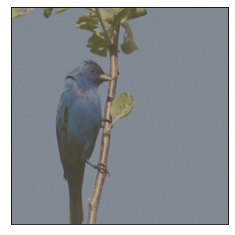

In [15]:
img = batch['GT'][0].numpy()

_,ax = plt.subplots(1,1)
#ax.imshow(img.transpose(1,2,0))
plot_imagenet(ax, img)

batch['GT'].size()

In [11]:
batch['GT_name']

['ILSVRC2012_val_00000414.JPEG',
 'ILSVRC2012_val_00001462.JPEG',
 'ILSVRC2012_val_00002071.JPEG',
 'ILSVRC2012_val_00002449.JPEG']

(torch.Size([4, 3, 256, 256]), array([0., 1.], dtype=float32))

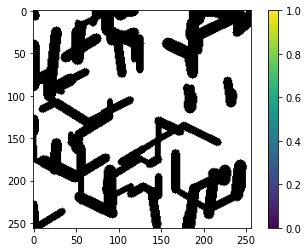

In [12]:
img = batch['gt_keep_mask'][0].numpy()

_,ax = plt.subplots(1,1)
cbar = ax.imshow(img.transpose(1,2,0))
plt.colorbar(cbar)

batch['gt_keep_mask'].size(), np.unique(img)

In [13]:
img = batch['GT'][0].numpy()
mask = batch['gt_keep_mask'][0].numpy()

Superpixel masks

In [16]:
from src.explainers.helper import generate_superpixel

In [31]:
from src.experiments.resources import load_data, load_imputer

In [33]:
root_data = '/media/vielhaben/Data1/ImageNet-complete/val'
dataset='imagenet'
root_experiments = '/home/vielhaben/git/conditional-explainer/data/experiments'
params = ParamsImputation(n_superpixel=100, compactness_slic=1., imputer_name='diffusion',
                            root_data=root_data, dataset=dataset,
                            root_experiments=root_experiments)

images = load_data(dataset=params.dataset, root=params.root_data, n_samples=3,
                    train=False, format_numpy=False)

In [39]:
images[0].image[None]

array([[[[2.060536 , 1.9064132, 1.9920369, ..., 2.0434113, 2.0434113,
          2.11191  ],
         [2.0776608, 1.923538 , 1.9749122, ..., 2.0091617, 2.0262864,
          2.0947855],
         [2.060536 , 1.9064132, 1.9406626, ..., 2.0091617, 2.0091617,
          2.0947855],
         ...,
         [2.0947855, 1.9064132, 1.9920369, ..., 2.0262864, 2.0262864,
          2.0947855],
         [2.11191  , 1.923538 , 1.9920369, ..., 2.0434113, 2.0434113,
          2.0947855],
         [2.1461596, 1.9920369, 2.0262864, ..., 2.0776608, 2.0434113,
          2.0947855]],

        [[2.2184873, 2.0609243, 2.1484594, ..., 2.2184873, 2.2184873,
          2.2885156],
         [2.235994 , 2.0784314, 2.1484594, ..., 2.1834733, 2.2009804,
          2.2710083],
         [2.2184873, 2.0609243, 2.1309524, ..., 2.1834733, 2.1834733,
          2.2710083],
         ...,
         [2.2535014, 2.0609243, 2.1484594, ..., 2.2009804, 2.2009804,
          2.2710083],
         [2.2710083, 2.0784314, 2.1659663, ..., 2.

In [17]:
image = batch['GT'][0].numpy()

segmentation = generate_superpixel(image, 100,
                                    compactness=1.)
superpixels = np.unique(segmentation)
# ensure that always the same superpixels are occluded
rng = np.random.default_rng(0)
rng.shuffle(superpixels)        # get fixed random ordering

n_occluded_superpixels = 10
occluded_superpixels = superpixels[:n_occluded_superpixels]
mask = 0
for s in occluded_superpixels:
    mask += segmentation == s
mask = (~(mask==1)).astype(float)

In [ ]:
imag

In [18]:
mask.shape

(3, 256, 256)

In [19]:
np.unique(mask)

array([0., 1.])

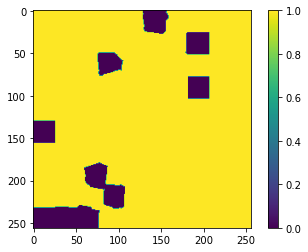

In [20]:
cbar = plt.imshow(mask[0])
plt.colorbar(cbar)

# Sampling

In [21]:
from numpy.typing import NDArray

In [22]:
def numpy_to_tensor(x, cuda: bool=True, unsqueeze_0: bool= True):
    x = torch.tensor(x, dtype=torch.float32)
    if unsqueeze_0:
        x = x.unsqueeze(dim=0)
    return x

In [23]:
#x = numpy_to_tensor(img)
#gt = numpy_to_tensor(mask)

batch_size = 1
x = batch['GT'][:1].to(device)
gt = numpy_to_tensor(mask).to(device) #batch['gt_keep_mask'].to(device)
y = torch.randint(low=0, high=NUM_CLASSES, size=(batch_size,), device=device)

model_kwargs = {'gt':x, 'gt_keep_mask':gt, 'y':y}

In [30]:
x.min(), x.max()

(tensor(-1., device='cuda:0'), tensor(1., device='cuda:0'))

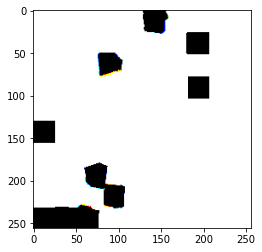

In [24]:
plt.imshow(gt[0].cpu().numpy().transpose(1,2,0))

In [25]:
def model_fn(x, t, y=None, gt=None, **kwargs):
        assert y is not None
        #return model(x, t, y if conf.class_cond else None, gt=gt)
        return model(x, t, y, gt=gt)



In [26]:
sample_fn = (diffusion.p_sample_loop if not conf.use_ddim else diffusion.ddim_sample_loop)

show_progress = True


result = sample_fn(
                    model_fn,
                    (batch_size, 3, conf.image_size, conf.image_size),
                    clip_denoised=conf.clip_denoised,
                    model_kwargs=model_kwargs,
                    cond_fn=cond_fn,
                    device=device,
                    progress=show_progress,
                    return_all=True,
                    conf=conf)

  0%|          | 0/4570 [00:00<?, ?it/s]

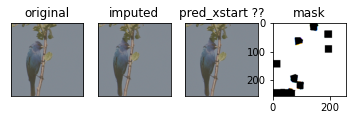

In [27]:
img_imputed = result['sample'][0].cpu().numpy()

_,ax = plt.subplots(1,4)
plot_imagenet(ax[0], img)
plot_imagenet(ax[1], img_imputed)
plot_imagenet(ax[2], result['pred_xstart'][0].cpu().numpy())
ax[3].imshow(gt[0].cpu().numpy().transpose(1,2,0))

ax[0].set_title("original")
ax[1].set_title("imputed")
ax[2].set_title("pred_xstart ??")
ax[3].set_title("mask")

plt.savefig("sample.png", dpi=500)


# Speed up using DEIS

https://github.com/qsh-zh/deis/

### How to apply DEIS
Example how to apply DEIS to 'Score-based generative Modelling thourgh SDEs' by Song et al.: (https://github.com/yang-song/score_sde_pytorch): https://github.com/qsh-zh/deis/blob/main/demo/continuous_cifar/deis.ipynb 


RePaint is based on OpenAI code for 'Diffusion Models Beat GANs on Image Synthesis' by Dhariwal et al. (https://github.com/openai/guided-diffusion)

Song and Dhariwal both build on implementation from Ho et al. for Denoising Diffusion Probabilistic Models (https://github.com/hojonathanho/diffusion).




### JAX vs. Pytorch

Repaint

In [20]:
# Create model and diffusion

model, diffusion = create_model_and_diffusion(**select_args(conf, model_and_diffusion_defaults().keys()), 
                                               conf=conf)

state_dict = torch.load(conf.model_path)
model.load_state_dict(state_dict)

model.to(device)
if conf.use_fp16:
    model.convert_to_fp16()
model.eval()

UNetModel(
  (time_embed): Sequential(
    (0): Linear(in_features=256, out_features=1024, bias=True)
    (1): SiLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (label_emb): Embedding(1000, 1024)
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 256, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=1024, out_features=512, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 256, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0.0, inplace=False)
          (3): 

In [9]:
# Repaint


def model_fn(x, t, y=None, gt=None, **kwargs):
        assert y is not None
        #return model(x, t, y if conf.class_cond else None, gt=gt)
        return model(x, t, y, gt=gt)

sample_fn = (diffusion.p_sample_loop if not conf.use_ddim else diffusion.ddim_sample_loop)



In [19]:
conf.use_ddim

False

In [ ]:
result = sample_fn(
                    model_fn,
                    (batch_size, 3, conf.image_size, conf.image_size),
                    clip_denoised=conf.clip_denoised,
                    model_kwargs=model_kwargs,
                    cond_fn=cond_fn,
                    device=device,
                    progress=True,
                    return_all=True,
                    conf=conf)

DEIS for Repaint Diffusion model

In [ ]:
#import jax_deis as deis

#def eps_fn(x_t, scalar_t):
#    vec_t = jnp.ones(x_t.shape[0]) * scalar_t
#    return eps_model(x_t, vec_t)


In [10]:
import th_deis as deis

In [21]:
eps_model = model_fn # TODO does this work? - what are the requiremtns for eps_model in

In [12]:

# pytorch
def eps_fn(x_t, scalar_t):
     vec_t = (torch.ones(x_t.shape[0])).float().to(x_t) * scalar_t
     with torch.no_grad():
         return eps_model(x_t, vec_t) # TODO what is eps_model??

In [14]:
sampling_eps = 1e-3   # from https://github.com/qsh-zh/deis/blob/main/demo/continuous_cifar/deis.ipynb
sampling_T = 10

In [15]:
# mappings between t and alpha in VPSDE
# we provide popular linear and cos mappings
t2alpha_fn,alpha2t_fn = deis.get_linear_alpha_fns(beta_0=0.01, beta_1=20)

vpsde = deis.VPSDE(  # variance preserving sde
    t2alpha_fn, 
    alpha2t_fn,
    sampling_eps, # sampling end time t_0
    sampling_T # sampling starting time t_T
)


In [16]:
sampler_fn = deis.get_sampler(
    # args for diffusion model
    vpsde,
    eps_fn,
    # args for timestamps scheduling
    ts_phase="t", # support "rho", "t", "log"
    ts_order=2.0,
    num_step=10,
    # deis choice
    method = "t_ab", # deis sampling algorithms: support "rho_rk", "rho_ab", "t_ab", "ipndm"
    ab_order= 3, # greater than 0, used for "rho_ab", "t_ab" algorithms, other algorithms will ignore the arg
    rk_method="3kutta" # used for "rho_rk" algorithms, other algorithms will ignore the arg
)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [17]:
sample = sampler_fn(noise)

NameError: name 'noise' is not defined

#### How to re-integrate DEIS-wrapped sampler into RePaint?

repaint sample function is method of the GaussianDiffusion object. This is where the trick in eq. 8 of repaint paper happens (combining x^known_t-1 and x^unknown_t-1). We can not just replace this sample method - then the whole repaint trick is missing.

comment from repaint's gaussian_diffusion.py:

    This code started out as a PyTorch port of Ho et al's diffusion models:
    https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py

    Docstrings have been added, as well as DDIM sampling (denoising diffusuin impliucit sample, https://nn.labml.ai/diffusion/stable_diffusion/sampler/ddim.html, not used in config that we use) and a new collection of beta schedules.